# Nash Q-Learning

In single-agent Q-learning, the agent updates its Q-value for a state-action pair by considering the immediate reward and the discounted maximum Q-value of the next state. The formula is something like:
$$
Q(s, a) = (1 - α) * Q(s, a) + α * [r + γ * max_a’ Q(s’, a’)]
$$

In the multiagent case, like Nash Q-learning, the environment isn't stationary because other agents are also learning. So the next state's value isn't just based on the agent's own actions but also the joint actions of all agents. 

$$
Q_i^{t+1}(s, a_1, ..., a_n) = (1 - α_t) Q_i^t(s, a_1, ..., a_n) + α_t [r_i^t + β * NashQ_i^t(s')]
$$

So the key difference from single-agent Q-learning is replacing the $ max_a’ Q(s’, a’) $ with $ NashQ_i^t(s')$, which is the expected value assuming all agents play a Nash equilibrium strategy in the next state s', under the current Q values.



## What is $ NashQ_i^t(s')$ ?

The paper defines NashQ_i^t(s') as π_1(s')...π_n(s') · Q_i^t(s'), where π_j(s') is the strategy (probability distribution over actions) for agent j in state s', and the product represents the joint strategy. The dot product with Q_i^t(s') would then be the expected Q-value for agent i under the joint Nash equilibrium strategy.

Intuiation behind $ NashQ_i^t(s') π_1(s')...π_n(s') · Q_i^t(s') $

This represents the expected future payoff for agent 
i in state s', assuming all agents follow their Nash equilibrium strategies.


So to compute NashQ_i^t(s'), we need to:

1. For the next state s', consider the current Q-values for all agents, Q_1^t(s'), ..., Q_n^t(s').

2. Solve for a Nash equilibrium in the stage game defined by these Q-values. This involves finding a set of strategies (π_1, ..., π_n) such that each agent's strategy is a best response to the others. 
> This means solving for set of Nash Equilibriums under the current Q values
> This seems computationally expensive, as u have to solve the Nash equilibrium defined by that Q value for each update

3. Calculate the expected Q-value for agent i under this equilibrium, which is the sum over all joint actions (a_1, ..., a_n) of the product of the strategies π_1(a_1)...π_n(a_n) multiplied by Q_i^t(s', a_1, ..., a_n).

In standard Q-learning, you update the Q-value for the current state and action taken. Here, it's similar. Even though the Q-function is defined for all state-action tuples, during each time step, the agent only updates the entry corresponding to the current state (s) and the joint action (a¹, ..., aⁿ) that was actually taken. Other entries remain unchanged. This is called asynchronous because you don't update all Q-values simultaneously; only those that are actually experienced. This is practical because in large state-action spaces, you can't update everything at once, so you focus on the parts you visit.

# Environment Setup
We'll create a custom 2-agent grid world using Gymnasium.
Key Features:

Grid size: 3x3

Agents both start at (1,1).

Goals: Fixed positions (0,0) for agent 1, and (2,2) for agent 2.

Actions: [UP, DOWN, LEFT, RIGHT] (4 actions per agent).

Observations: Positions of both agents.

Rewards:

+10 for reaching the goal.

-1 for collisions (if both agents choose the same cell).

-0.1 per step to encourage efficiency.

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

grid_size = 3
max_steps = 100000
class MultiAgentGridWorld(gym.Env):

    metadata = {'render_modes': ['human'], 'render_fps': 4}
    
    def __init__(self):
        self.grid_size = grid_size
        self.n_agents = 2
        self.goals = [(0, 0), (0, 2)]  # Agent 1 and 2 goals
        self.max_steps = max_steps
        self.init_positions = [(2, 2), (2, 0)] # Agent 1 and 2 init positions
        

        # Action space: 4 actions per agent
        self.action_space = spaces.MultiDiscrete([4, 4])

        # Observation space: positions of both agents
        self.observation_space = spaces.Dict({
            "agent1": spaces.Box(0, self.grid_size-1, shape=(2,), dtype=int),
            "agent2": spaces.Box(0, self.grid_size-1, shape=(2,), dtype=int)
        })

        # Initialize agent positions
        self.reset()

    def reset(self):
        self.agent1_pos, self.agent2_pos = self.init_positions
        self.steps = 0
        return self._get_obs()

    def _get_obs(self):
        return {
            "agent1": np.array(self.agent1_pos),
            "agent2": np.array(self.agent2_pos)
        }

    def step(self, actions):
        self.steps += 1

        # Move agents
        new_pos1 = self._move(self.agent1_pos, actions[0])
        new_pos2 = self._move(self.agent2_pos, actions[1])

        agent1_done = new_pos1 == self.goals[0]
        agent2_done = new_pos2 == self.goals[1]
        done = agent1_done or agent2_done

        reward1 = reward2 = 0
        if done:
            if agent1_done and agent2_done:
                reward1 = reward2 = 100
            elif agent1_done:
                reward1 = 100
            else:
                reward2 = 100
        else:
            # Check for collisions
            if new_pos1 == new_pos2:
                reward1 = reward2 = -1
                # Revert to agent's previous positions
                new_pos1 = self.agent1_pos
                new_pos2 = self.agent2_pos
                done = False  # Agents stay in place

            else:
                reward1 = reward2 = -0.1


        # Enforce agent to move a better efficiency
        
        # Force episode end after max_steps
        done = done or self.steps >= self.max_steps

        # Update agent positions
        self.agent1_pos = new_pos1
        self.agent2_pos = new_pos2
        
        return self._get_obs(), (reward1, reward2), done, {}

    def _move(self, pos, action):
        x, y = pos
        if action == 0:  # UP
            x = max(0, x-1)
        elif action == 1:  # DOWN
            x = min(self.grid_size-1, x+1)
        elif action == 2:  # LEFT
            y = max(0, y-1)
        elif action == 3:  # RIGHT
            y = min(self.grid_size-1, y+1)
        return (x, y)
    
    def render(self):
        grid = np.full((3, 3), '·', dtype='<U3')
        
        # Mark goals
        grid[self.goals[0]] = 'G1'
        grid[self.goals[1]] = 'G2'
        
        # Mark agents
        grid[self.agent1_pos] = 'A1'
        grid[self.agent2_pos] = 'A2'
        
        # Print with paper's orientation
        print("Current State (Paper's Layout):")
        for row in grid:
            print(" ".join(f"{cell:^3}" for cell in row))
        print()

In [2]:
env = MultiAgentGridWorld()
env.render()

Current State (Paper's Layout):
G1   ·  G2 
 ·   ·   · 
A2   ·  A1 



## Plot Environment

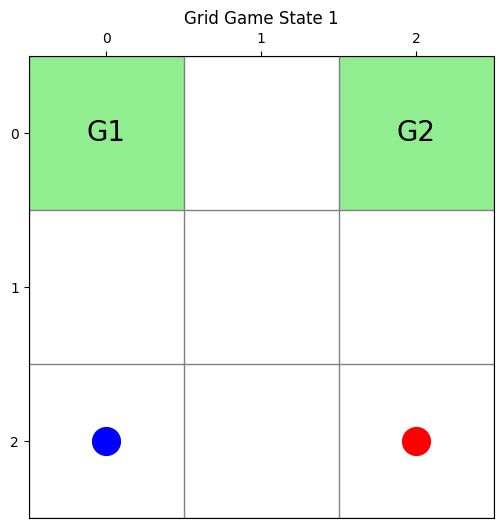

In [3]:


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def plot_env_state(env):
    fig, ax = plt.subplots(figsize=(6, 6))

    # 1) Draw grid lines at 0, 1, 2, 3
    for x in range(4):
        ax.axvline(x, color='gray', linestyle='-', linewidth=1)
    for y in range(4):
        ax.axhline(y, color='gray', linestyle='-', linewidth=1)
    
    # 2) Set axis limits
    ax.set_xlim(0, 3)
    ax.set_ylim(0, 3)
    
    # 3) Place ticks in the middle of each cell and label them 0, 1, 2
    ax.set_xticks([0.5, 1.5, 2.5])
    ax.set_yticks([0.5, 1.5, 2.5])
    ax.set_xticklabels(['0', '1', '2'])
    ax.set_yticklabels(['0', '1', '2'])

    # Move x-axis to the top
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

    # Invert y-axis to match paper's layout
    ax.invert_yaxis()
    ax.set_title("Grid Game State 1")

    # Plot goals (example: green cells at top-left and top-right)
    ax.add_patch(patches.Rectangle((0, 0), 1, 1, facecolor='lightgreen'))
    ax.add_patch(patches.Rectangle((2, 0), 1, 1, facecolor='lightgreen'))
    ax.text(0.5, 0.5, 'G1', ha='center', va='center', fontsize=20)
    ax.text(2.5, 0.5, 'G2', ha='center', va='center', fontsize=20)

    # Plot agent positions
    a1_row, a1_col = env.agent1_pos
    a2_row, a2_col = env.agent2_pos
    
    # Convert to "paper coordinates"
    def paper_coords(row, col):
        return (col + 0.5, row + 0.5)
    
    ax.plot(*paper_coords(a1_row, a1_col), 'ro', markersize=20)
    ax.plot(*paper_coords(a2_row, a2_col), 'bo', markersize=20)
    
    plt.show()


# Test with initial state
env = MultiAgentGridWorld()
env.reset()
plot_env_state(env)

## Nash Q-Learning Implementation

In [4]:
import numpy as np
from nashpy import Game  # For Nash equilibrium computation
import matplotlib.pyplot as plt

class NashQLearner:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.5):
        self.env = env
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_history = []

        # Initialize Q-tables for both agents
        self.Q1 = np.zeros((env.grid_size, env.grid_size, env.grid_size, env.grid_size, 4, 4))
        self.Q2 = np.zeros((env.grid_size, env.grid_size, env.grid_size, env.grid_size, 4, 4))

    def get_action(self, state, explore=True):
        # ε-greedy action selection
        if explore and np.random.rand() < self.epsilon:
            return (np.random.randint(0, 4), np.random.randint(0, 4))
        else:
            # Compute Nash equilibrium for current state
            s = state["agent1"][0], state["agent1"][1], state["agent2"][0], state["agent2"][1]
            game = Game(self.Q1[s], self.Q2[s])
            equilibria = list(game.support_enumeration())
            if len(equilibria) == 0:
                return (np.random.randint(0, 4), np.random.randint(0, 4))
            else:
                # Select first equilibrium (could prioritize others)
                pi1, pi2 = equilibria[0]
                # Select a mixed strategy equilibrium from the equilibria list
                a1 = np.random.choice([0, 1, 2, 3], p=pi1)
                a2 = np.random.choice([0, 1, 2, 3], p=pi2)
                return (a1, a2)

    def update(self, state, actions, rewards, next_state):
        s = (state["agent1"][0], state["agent1"][1], state["agent2"][0], state["agent2"][1])
        a1, a2 = actions
        r1, r2 = rewards

        # Compute Nash Q-values for next state
        s_next = (next_state["agent1"][0], next_state["agent1"][1], next_state["agent2"][0], next_state["agent2"][1])
        game_next = Game(self.Q1[s_next], self.Q2[s_next])
        equilibria_next = list(game_next.support_enumeration())
        if len(equilibria_next) == 0:
            nash_q1 = 0
            nash_q2 = 0
        else:
            pi1_next, pi2_next = equilibria_next[0]
            # Computing Nash Q values of the product of the strategies π_1(a_1)...π_n(a_n) multiplied by Q_i^t(s', a_1, ..., a_n). 
            nash_q1 = np.sum(pi1_next * np.sum(pi2_next * self.Q1[s_next], axis=-1))
            nash_q2 = np.sum(pi1_next * np.sum(pi2_next * self.Q2[s_next], axis=-1))

        # Update Q-tables
        self.Q1[s][a1][a2] += self.alpha * (r1 + self.gamma * nash_q1 - self.Q1[s][a1][a2])
        self.Q2[s][a1][a2] += self.alpha * (r2 + self.gamma * nash_q2 - self.Q2[s][a1][a2])

    def plot_learning_curve(self, episode_rewards):
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(len(episode_rewards)), 
                [r[0] for r in episode_rewards], label="Agent 1")
        plt.plot(np.arange(len(episode_rewards)), 
                [r[1] for r in episode_rewards], label="Agent 2")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Learning Curve")
        plt.legend()
        plt.show()
    

## Training Loop

c:\Users\wangy\anaconda3\envs\Multi-Agent-General\Lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (16) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)
c:\Users\wangy\anaconda3\envs\Multi-Agent-General\Lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (14) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)
c:\Users\wangy\anaconda3\envs\Multi-Agent-General\Lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (12) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


Episode 000 | Avg Reward: [-4.6 95.4]


c:\Users\wangy\anaconda3\envs\Multi-Agent-General\Lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (10) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)
c:\Users\wangy\anaconda3\envs\Multi-Agent-General\Lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (8) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)
c:\Users\wangy\anaconda3\envs\Multi-Agent-General\Lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (6) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)
c:\Use

Episode 010 | Avg Reward: [68.19 28.19]


c:\Users\wangy\anaconda3\envs\Multi-Agent-General\Lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (2) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


Episode 020 | Avg Reward: [48.14 48.14]
Episode 030 | Avg Reward: [38.59 58.59]
Episode 040 | Avg Reward: [58.69 38.69]
Episode 050 | Avg Reward: [79.23 19.23]
Episode 060 | Avg Reward: [49.07 49.07]
Episode 070 | Avg Reward: [59.06 39.06]
Episode 080 | Avg Reward: [69.59 29.59]


c:\Users\wangy\anaconda3\envs\Multi-Agent-General\Lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (0) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


Episode 090 | Avg Reward: [59.56 49.56]
Episode 100 | Avg Reward: [79.46 29.46]
Episode 110 | Avg Reward: [89.65 49.65]
Episode 120 | Avg Reward: [99.68 99.68]
Episode 130 | Avg Reward: [99.7 99.7]
Episode 140 | Avg Reward: [99.7 99.7]
Episode 150 | Avg Reward: [99.7 99.7]
Episode 160 | Avg Reward: [99.7 99.7]
Episode 170 | Avg Reward: [99.7 99.7]
Episode 180 | Avg Reward: [99.7 99.7]
Episode 190 | Avg Reward: [99.7 99.7]


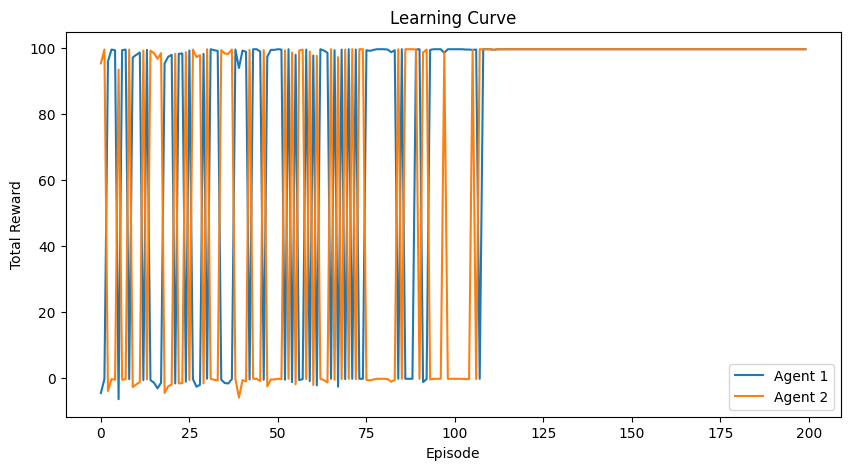

In [5]:
env = MultiAgentGridWorld()
agent = NashQLearner(env)
all_episode_rewards = []
epsilon_decay = []
n_episodes = 200
for episode in range(n_episodes):
    state = env.reset()
    done = False
    total_reward = [0, 0]
    
    while not done:
        actions = agent.get_action(state)
        next_state, rewards, done, _ = env.step(actions)
        agent.update(state, actions, rewards, next_state)
        state = next_state
        total_reward[0] += rewards[0]
        total_reward[1] += rewards[1]
        
    
    all_episode_rewards.append(total_reward)
    agent.epsilon *= 0.95
    epsilon_decay.append(agent.epsilon)
    
    if episode % 10 == 0:
        
        print(f"Episode {episode:03d} | Avg Reward: {np.mean(all_episode_rewards[-10:], axis=0)}")

# Plot final reward curve
agent.plot_learning_curve(all_episode_rewards)

## Plotting Functions

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_q_values(agent, agent_id=1, state=(1, 1, 1, 1)):
    q_table = agent.Q1[state] if agent_id == 1 else agent.Q2[state]
    plt.figure(figsize=(8, 6))
    sns.heatmap(q_table, annot=True, fmt=".1f", cmap="viridis")

    # Define action names
    action_names = ["UP", "DOWN", "LEFT", "RIGHT"]
    # Print action names
    plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=action_names)
    plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=action_names)

    plt.xlabel("Agent 2 Actions")
    plt.ylabel("Agent 1 Actions")
    plt.title(f"Q-Values for Agent {agent_id} in State {state}")
    plt.show()

def visualize_trajectory(agent, env):
    state = env.reset()
    done = False
    trajectory1 = [state["agent1"]]
    trajectory2 = [state["agent2"]]

    while not done:
        actions = agent.get_action(state, explore=False)
        next_state, _, done, _ = env.step(actions)
        trajectory1.append(next_state["agent1"])
        trajectory2.append(next_state["agent2"])
        state = next_state

    plt.figure(figsize=(8, 8))
    
    # Convert coordinates to paper's layout (invert rows)
    def paper_coords(pos):
        return (pos[1], 2 - pos[0])  # (x, 2-row)

    # Plot trajectories with coordinate transformation
    plt.plot(*zip(*[paper_coords(p) for p in trajectory1]), 
            marker='o', label="Agent 1")
    plt.plot(*zip(*[paper_coords(p) for p in trajectory2]), 
            marker='s', label="Agent 2")
    
    # Plot goals using paper's coordinates
    plt.plot(0, 2, 'bs', markersize=15, label="Agent 1 Goal")  # (0,0) -> (0,2)
    plt.plot(2, 2, 'ro', markersize=15, label="Agent 2 Goal")  # (0,2) -> (2,2)
    
    # Set up grid parameters
    plt.xticks([0, 1, 2], ['0', '1', '2'])
    plt.yticks([0, 1, 2], ['2', '1', '0'])  # Inverted y-axis labels
    plt.grid(True)
    plt.xlim(-0.5, 2.5)
    plt.ylim(-0.5, 2.5)
    # plt.gca().invert_yaxis()  # Match paper's orientation
    
    # Move x-axis to the top
    plt.gca().xaxis.set_ticks_position('top')
    plt.gca().xaxis.set_label_position('top')
    
    plt.legend()
    plt.title("Agent Trajectories")
    plt.show()

def plot_exploration_decay(epsilon_decay):
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(epsilon_decay)), epsilon_decay)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Exploration Rate Decay")
    plt.show()

## Check Learned Policy

c:\Users\wangy\anaconda3\envs\Multi-Agent-General\Lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (10) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


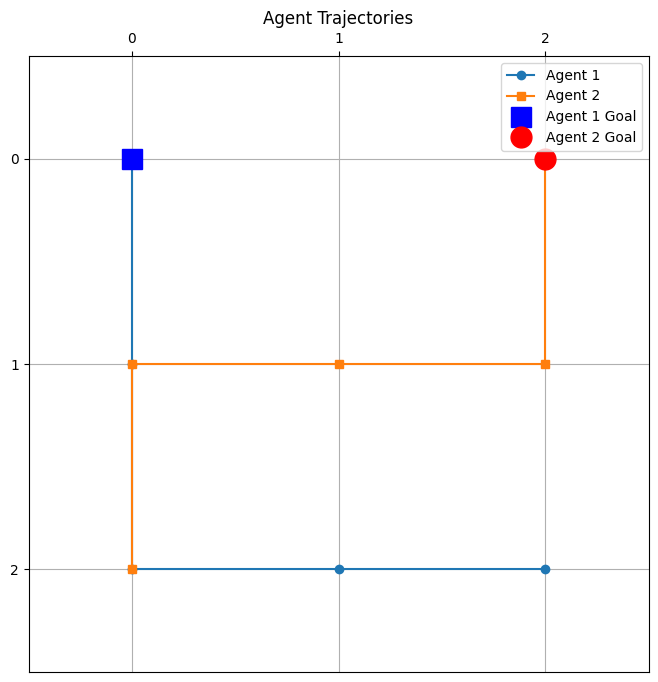

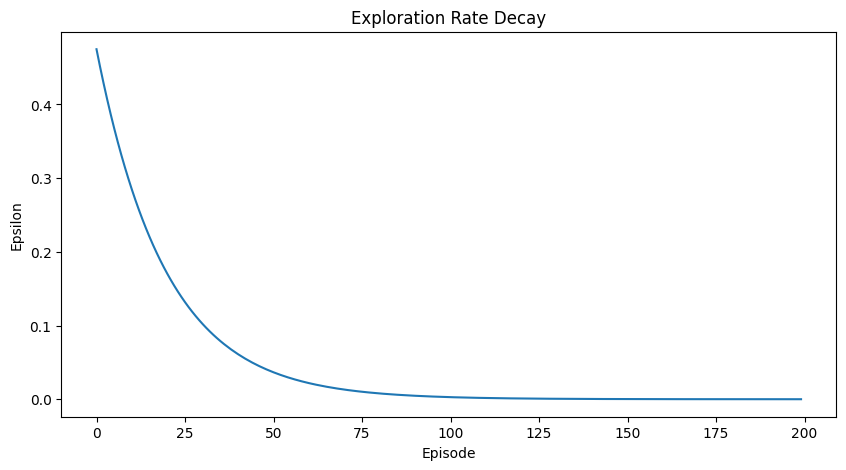

In [7]:
visualize_trajectory(agent, env)
plot_exploration_decay(epsilon_decay)

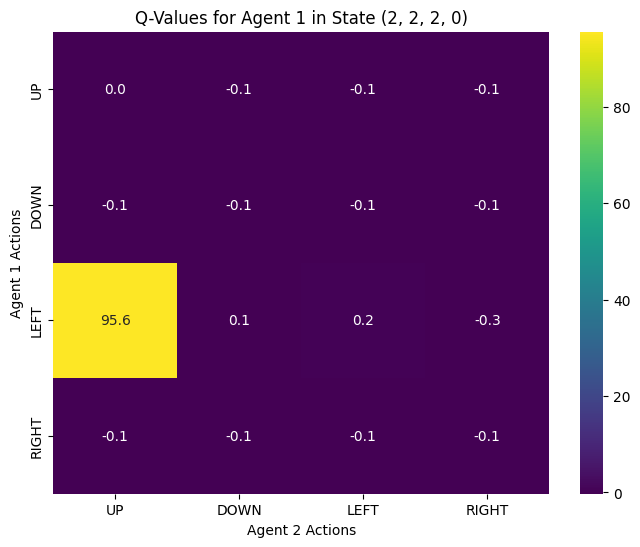

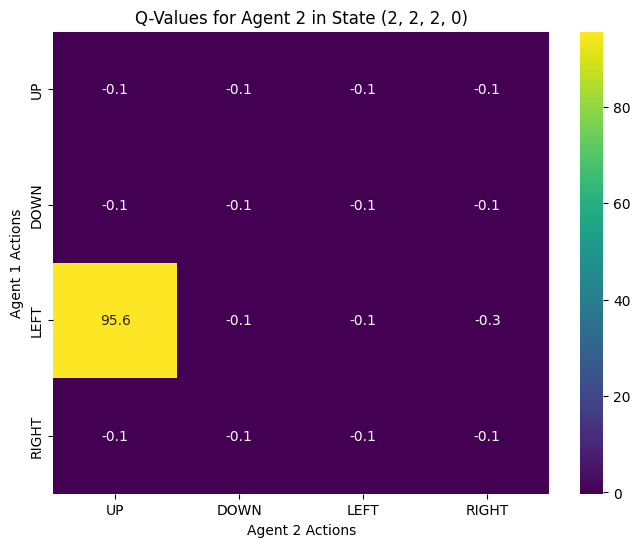

In [8]:
plot_q_values(agent, agent_id=1, state=(2, 2, 2, 0))  
plot_q_values(agent, agent_id=2, state=(2, 2, 2, 0))

